In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

Place to get into the correct place for accessing the pickle file

In [4]:
cd  Desktop\V9_all_scans_dict_87_88_89_90_91_92_93_94_MD_81_to_1939.pickle

C:\Users\cae2\Desktop\V9_all_scans_dict_87_88_89_90_91_92_93_94_MD_81_to_1939.pickle


In [5]:
data_dict = pd.read_pickle("V9_all_scans_dict_87_88_89_90_91_92_93_94_MD_81_to_1939.pickle")
print(f"Imported files with keys {data_dict.keys()}")

Imported files with keys dict_keys([87, 88, 89, 90, 91, 92, 93, 94])


In [6]:
df = data_dict[88]

In [7]:
ds = xr.Dataset.from_dataframe(df, sparse=True)
ds

Format,coo
Data Type,float64
Shape,"(504, 233)"
nnz,63831
Density,0.5435571224197834
Read-only,True
Size,748.0K
Storage ratio,0.8
Format,coo
Data Type,float64
Shape,"(504, 233)"


In [8]:
# create the flat array
detectors = ds.detector.to_numpy().ravel()
# iterate through the array and only keep string data
detectors = [detector for detector in detectors if type(detector) is str]
# convert to a set to get unique values
list(set(detectors))

['IR']

In [9]:
# create the flat array
channels = ds.channel.to_numpy().ravel()
# iterate through the array and only keep string data
channels = [channel for channel in channels if type(channel) is str]
# convert to a set to get unique values
list(set(channels))

['B']

In [10]:
def unique_string_from_sparse_dataarray(da):
    xs = da.to_numpy().ravel()
    xs = [x for x in xs if type(x) is str]
    xs = list(set(xs))
    if len(xs) == 1:
        return xs[0]
    else:
        return xs

In [11]:
unique_string_from_sparse_dataarray(ds.channel)

'B'

In [12]:
dataset_dict = {
    key: xr.Dataset.from_dataframe(df, sparse=True) for key, df in data_dict.items()
}  # exactly is just data_dict

In [13]:
keys = list(
    dataset_dict.keys()
)  # list because error, and maybe this disconnects data from dictionary
for key in keys:
    ds = dataset_dict.pop(key)
    new_key = unique_string_from_sparse_dataarray(
        ds.channel
    ), unique_string_from_sparse_dataarray(ds.detector)
    dataset_dict[new_key] = ds
dataset_dict

{('B',
  'ESR'): <xarray.Dataset>
 Dimensions:              (scan_time: 691, wavelength: 902)
 Coordinates:
   * scan_time            (scan_time) float64 82.47 82.66 ... 1.939e+03 1.939e+03
   * wavelength           (wavelength) float64 263.9 264.0 ... 2.399e+03
 Data variables:
     pt_time              (scan_time, wavelength) float64 <COO: nnz=51612, fill_value=nan>
     sirr                 (scan_time, wavelength) float64 <COO: nnz=51612, fill_value=nan>
     imode                (scan_time, wavelength) float64 <COO: nnz=51612, fill_value=nan>
     detector             (scan_time, wavelength) object <COO: nnz=51612, fill_value=nan>
     channel              (scan_time, wavelength) object <COO: nnz=51612, fill_value=nan>
     solar_exposure_days  (scan_time, wavelength) float64 <COO: nnz=51612, fill_value=nan>
     activity_name        (scan_time, wavelength) object <COO: nnz=51612, fill_value=nan>,
 ('B',
  'IR'): <xarray.Dataset>
 Dimensions:              (scan_time: 504, wavelengt

In [14]:
dataset_dict.keys()

dict_keys([('B', 'ESR'), ('B', 'IR'), ('B', 'VIS'), ('B', 'UV'), ('C', 'ESR'), ('C', 'IR'), ('C', 'VIS'), ('C', 'UV')])

In [15]:
da = ds.sirr[:, 400]  # get the time series of the ESR at the 400th wavelength
da = da.as_numpy()  # convert to numpy array so not sparse now
da = da.dropna(dim="scan_time")  # drop elements with no value
da.interp(scan_time=750)  # interpolate the value to the scan time 750

# note this all could have been a single line just appending the methods at the end

<xarray.DataArray 'sirr' ()>
array(0.05620793)
Coordinates:
    wavelength  float64 223.2
    scan_time   int32 750

In [16]:
ds_vis_a = dataset_dict["B", "VIS"]
ds_esr_a = dataset_dict["B", "ESR"]

Text(0, 0.5, 'wavelength exists in\nESR data')

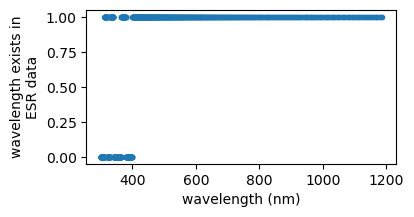

In [17]:
good_wl = [wl in ds_esr_a.wavelength.values for wl in ds_vis_a.wavelength.values]
fig, ax = plt.subplots(1)
ax.plot(ds_vis_a.wavelength.values, good_wl, ".")
fig.set_size_inches([4, 2])
ax.set_xlabel("wavelength (nm)")
ax.set_ylabel("wavelength exists in\nESR data")

In [18]:
ds_combined = xr.combine_by_coords(
    [ds_vis_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",
)
ds_combined.as_numpy()

<xarray.Dataset>
Dimensions:              (scan_time: 1640, wavelength: 1147)
Coordinates:
  * scan_time            (scan_time) float64 81.31 82.47 ... 1.939e+03 1.939e+03
  * wavelength           (wavelength) float64 263.9 264.0 ... 2.399e+03
Data variables:
    pt_time              (scan_time, wavelength) float64 nan nan nan ... nan nan
    sirr                 (scan_time, wavelength) float64 nan nan nan ... nan nan
    imode                (scan_time, wavelength) float64 nan nan nan ... nan nan
    detector             (scan_time, wavelength) object nan nan nan ... nan nan
    channel              (scan_time, wavelength) object nan nan nan ... nan nan
    solar_exposure_days  (scan_time, wavelength) float64 nan nan nan ... nan nan
    activity_name        (scan_time, wavelength) object nan nan nan ... nan nan
    sirr_esr             (scan_time, wavelength) float64 nan nan nan ... nan nan

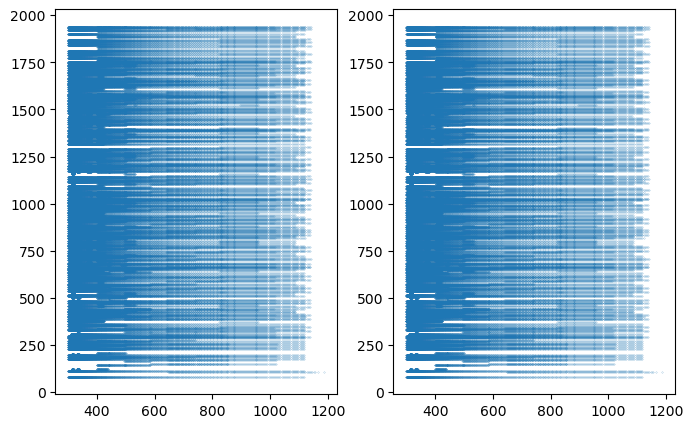

In [19]:
fig,ax = plt.subplots(1,2)
x,y = np.where(ds_vis_a.sirr.to_numpy()>0)
ax[0].plot(ds_vis_a.wavelength.to_numpy()[y],ds_vis_a.scan_time.to_numpy()[x],'.',markersize=.25)
x,y = np.where(ds_combined.sirr.to_numpy()>0)
ax[1].plot(ds_combined.wavelength.to_numpy()[y],ds_combined.scan_time.to_numpy()[x],'.',markersize=.25)
fig.set_size_inches([8,5])

In [20]:
ds_combined["sirr_esr_interp"] = ds_combined.sirr_esr.interpolate_na(
    dim="scan_time", method="linear"
)

In [21]:
da_ratio = (ds_combined.sirr / ds_combined.sirr_esr_interp)

In [22]:
scan_time = ds_combined.scan_time.to_numpy()

In [23]:
da_ratio_interp = da_ratio.interpolate_na(
    dim="scan_time", method="linear"
)

Text(0.5, 1.0, 'TSIS SIM Channel B VIS Diode Degredation')

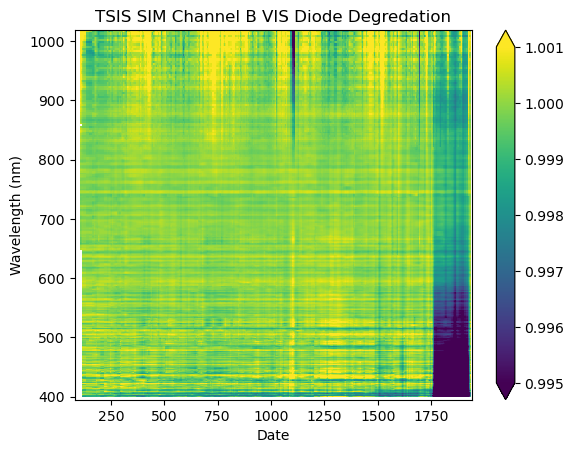

In [29]:
fig, ax=plt.subplots(1)
da_ratio_interp.sel(wavelength = slice(395, 1020)).plot(x = "scan_time", robust = True, vmin = .995, vmax = 1.001)
ax.set_xlabel("Date")
ax.set_ylabel("Wavelength (nm)")
ax.set_title("TSIS SIM Channel B VIS Diode Degredation")

In [28]:
plt.gci()

<Figure size 640x480 with 0 Axes>

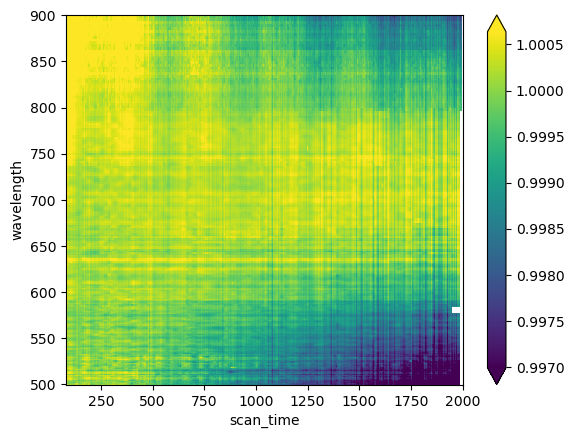

In [34]:
da_ratio_interp.sel(wavelength = slice(500, 900)).plot(x = "scan_time", robust = True)

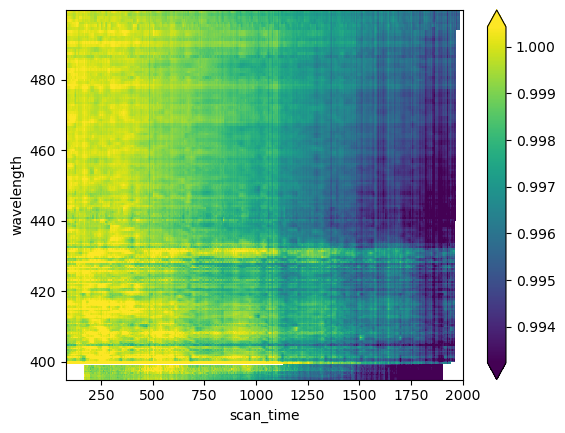

In [35]:
da_ratio_interp.sel(wavelength = slice(395, 500)).plot(x = "scan_time", robust = True)

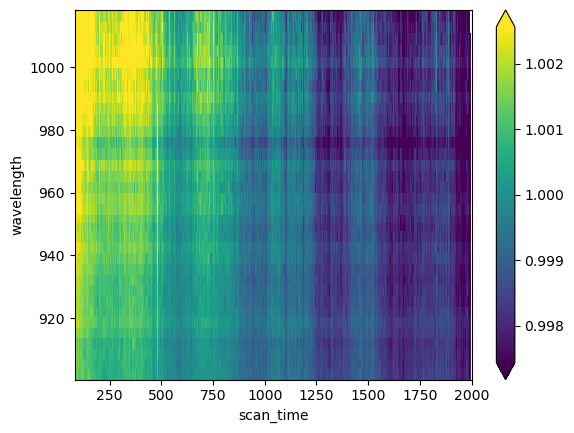

In [36]:
da_ratio_interp.sel(wavelength = slice(900, 1020)).plot(x = "scan_time", robust = True)